In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from statsmodels.tools.eval_measures import aic, bic

import warnings

warnings.filterwarnings("ignore") # Игнорируем предупреждения для чистоты вывода
plt.style.use('seaborn-v0_8-whitegrid') # Стиль графиков

import os
data_dir = './data'

# Анализ влияния волатильности инфляции на рост ВВП США (1961-2014)

## 1. Загрузка данных

--- 
Загрузка данных

---

In [3]:
try:
    df = pd.read_excel(os.path.join(data_dir, 'InfGrowth.xlsx'),header=0)
    df.set_index("Time", inplace=True)
    display(df.head())
except FileNotFoundError:
    assert False , "Файл InfGrowth.xlsx не найден. Пожалуйста, убедитесь, что файл находится в правильной директории."

,GDPGrowth,Inflation
Time,,
1961,2.3,1.075182
1962,6.1,1.116071
1963,4.4,1.214128
1964,5.8,1.308615
1965,6.4,1.668461


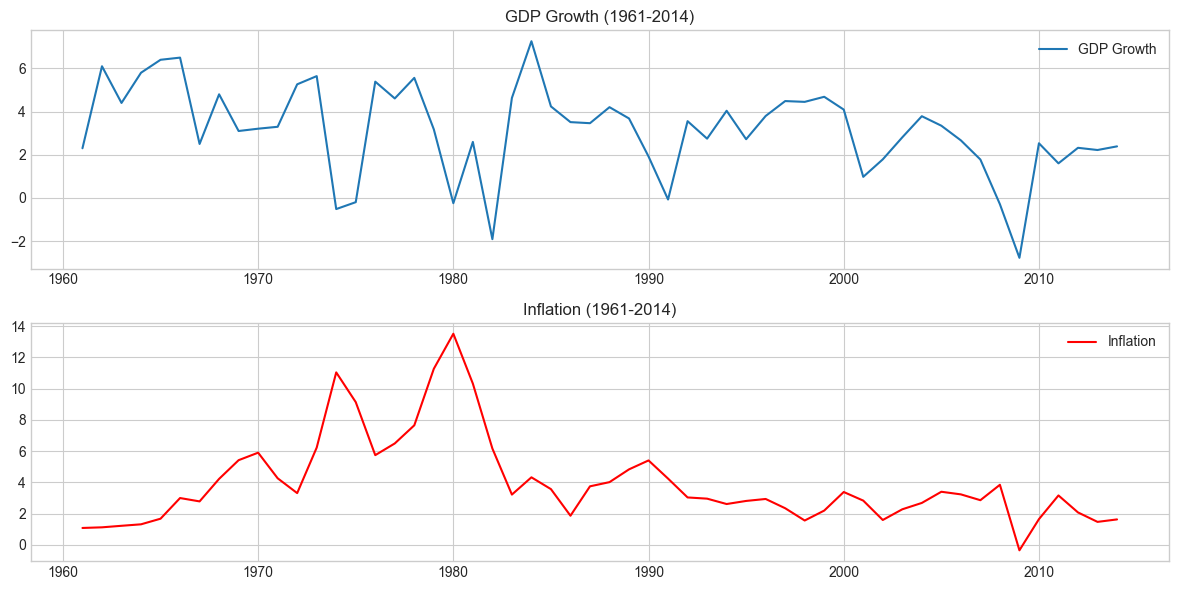

In [4]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df["GDPGrowth"], label="GDP Growth")
plt.title("GDP Growth (1961-2014)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df["Inflation"], label="Inflation", color="r")
plt.title("Inflation (1961-2014)")
plt.legend()
plt.tight_layout()
plt.show()

## 2. Проверка стационарности (а)

In [5]:
def adf_test(series, title=""):
    result = adfuller(series)
    print(f"ADF Test for {title}:")
    print(f"Test Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] > 0.01:
        print("Ряд нестационарен. Нужно брать разности.\n")
    else:
        print("Ряд стационарен.\n")

# Тест для GDPGrowth
adf_test(df["GDPGrowth"], "GDP Growth")

# Тест для Inflation
adf_test(df["Inflation"], "Inflation")

# Разности первого порядка
df["GDPGrowth_diff"] = df["GDPGrowth"].diff()
df["Inflation_diff"] = df["Inflation"].diff()

# Удаляем NaN
df.dropna(inplace=True)

# Повторный тест для разностей
adf_test(df["GDPGrowth_diff"], "GDP Growth (diff)")
adf_test(df["Inflation_diff"], "Inflation (diff)")

ADF Test for GDP Growth:
Test Statistic: -5.006240792052021
p-value: 2.1570570501272988e-05
Critical Values:
   1%: -3.560242358792829
   5%: -2.9178502070837
   10%: -2.5967964150943397
Ряд стационарен.

ADF Test for Inflation:
Test Statistic: -2.0173360378862575
p-value: 0.2790239602564182
Critical Values:
   1%: -3.5656240522121956
   5%: -2.920142229157715
   10%: -2.598014675124952
Ряд нестационарен. Нужно брать разности.

ADF Test for GDP Growth (diff):
Test Statistic: -3.7702170308737744
p-value: 0.003227162779996154
Critical Values:
   1%: -3.5925042342183704
   5%: -2.931549768951162
   10%: -2.60406594375338
Ряд стационарен.

ADF Test for Inflation (diff):
Test Statistic: -6.946727232107108
p-value: 9.928320599315347e-10
Critical Values:
   1%: -3.5656240522121956
   5%: -2.920142229157715
   10%: -2.598014675124952
Ряд стационарен.



## 3. Тест Грейнджера (б)

In [11]:
# Подготовка данных для теста Грейнджера
max_lag = 4
test_result = grangercausalitytests(
    df[["GDPGrowth_diff", "Inflation_diff"]].dropna(), maxlag=max_lag
)

# Определение оптимального лага по AIC
best_lag = min(
    range(1, max_lag + 1),
    key=lambda lag: test_result[lag][0]["params_ftest"][0]
)
print(f"Оптимальный лаг: {best_lag}")

# Проверка причинности на уровне 1%
for lag in range(1, max_lag + 1):
    p_value = test_result[lag][0]["params_ftest"][1]
    print(f"Лаг {lag}: p-value = {p_value:.4f}")
    if p_value < 0.01:
        print("  → Существует причинность по Грейнджеру\n")
    else:
        print("  → Нет причинности по Грейнджеру\n")


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.5775 , p=0.0000  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=26.1136 , p=0.0000  , df=1
likelihood ratio test: chi2=21.0862 , p=0.0000  , df=1
parameter F test:         F=24.5775 , p=0.0000  , df_denom=48, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.9877 , p=0.0001  , df_denom=45, df_num=2
ssr based chi2 test:   chi2=24.4170 , p=0.0000  , df=2
likelihood ratio test: chi2=19.8831 , p=0.0000  , df=2
parameter F test:         F=10.9877 , p=0.0001  , df_denom=45, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.0751  , p=0.0002  , df_denom=42, df_num=3
ssr based chi2 test:   chi2=28.2629 , p=0.0000  , df=3
likelihood ratio test: chi2=22.3143 , p=0.0001  , df=3
parameter F test:         F=8.0751  , p=0.0002  , df_denom=42, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.0689  , p=0.0022  , df_d

## 4. GARCH-модель для волатильности инфляции (в)

Оптимальные параметры GARCH: p=1, q=0
                      Constant Mean - ARCH Model Results                      
Dep. Variable:         Inflation_diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -95.6688
Distribution:                  Normal   AIC:                           197.338
Method:            Maximum Likelihood   BIC:                           203.191
                                        No. Observations:                   52
Date:                Wed, May 14 2025   Df Residuals:                       51
Time:                        01:54:14   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0386      0.167

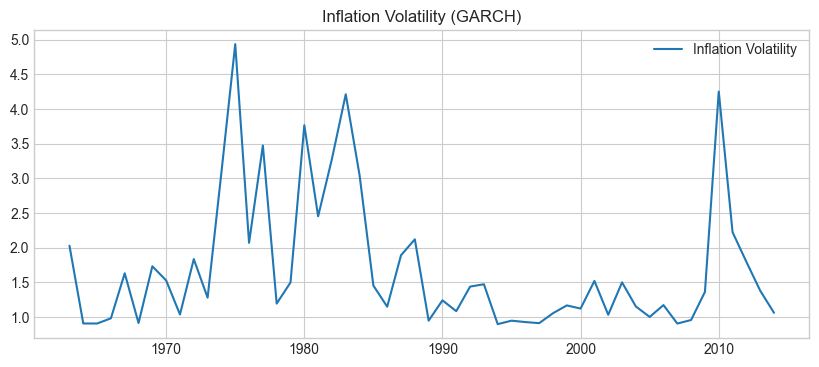

In [15]:
# Поиск оптимальных параметров GARCH через AIC
def find_best_garch(X, max_p=3, max_q=3):
    best_aic = np.inf
    best_params = None
    for p in range(0, max_p+1):
        for q in range(0, max_q+1):
            if p == 0 and q == 0:
                continue
            try:
                model = arch_model(X, vol="GARCH", p=p, q=q)
                result = model.fit(disp="off")
                current_aic = result.aic
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_params = (p, q)
            except:
                continue
    return best_params

# Оптимальные параметры
garch_params = find_best_garch(df["Inflation_diff"])
print(f"Оптимальные параметры GARCH: p={garch_params[0]}, q={garch_params[1]}")

# GARCH с оптимальными параметрами
am = arch_model(df["Inflation_diff"], vol="GARCH", p=garch_params[0], q=garch_params[1])
res = am.fit(disp="off")
print(res.summary())

# Сохранение условной дисперсии
df["Inflation_volatility"] = res.conditional_volatility
df["Inflation_volatility"].fillna(0, inplace=True)

# Визуализация волатильности
plt.figure(figsize=(10, 4))
plt.plot(df["Inflation_volatility"], label="Inflation Volatility")
plt.title("Inflation Volatility (GARCH)")
plt.legend()
plt.show()

## 5. ARMA-модель для ВВП (г)

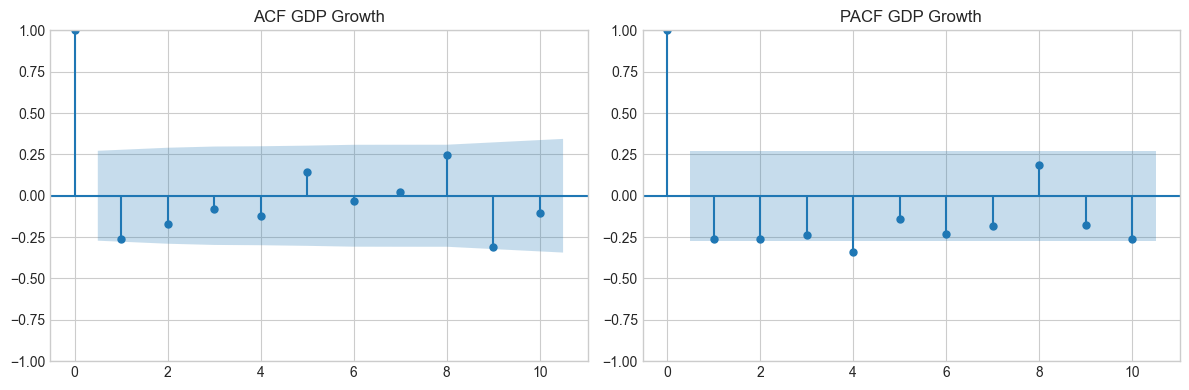

                               SARIMAX Results                                
Dep. Variable:         GDPGrowth_diff   No. Observations:                   52
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -107.707
Date:                Wed, 14 May 2025   AIC                            227.415
Time:                        01:56:07   BIC                            239.122
Sample:                             0   HQIC                           231.903
                                 - 52                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0557      0.033     -1.699      0.089      -0.120       0.009
ar.L1         -0.8404      2.702     -0.311      0.756      -6.135       4.455
ma.L1          0.1459      2.788      0.052      0.9

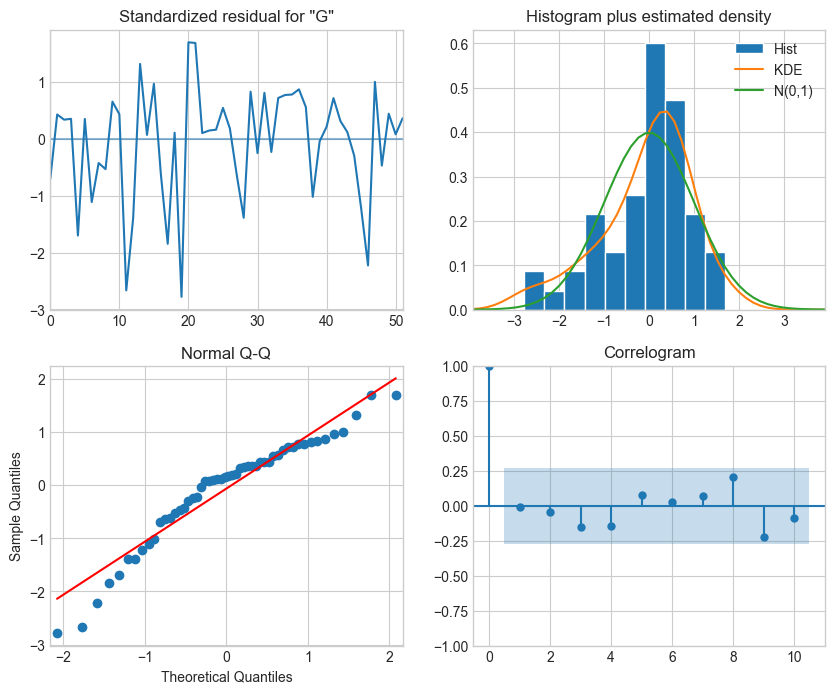

In [16]:
# ACF/PACF для выбора порядка ARMA
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(df["GDPGrowth_diff"], lags=10, ax=plt.gca())
plt.title("ACF GDP Growth")

plt.subplot(1, 2, 2)
plot_pacf(df["GDPGrowth_diff"], lags=10, ax=plt.gca())
plt.title("PACF GDP Growth")
plt.tight_layout()
plt.show()

# Определение параметров ARMA на основе ACF/PACF
# Пример: если PACF обрывается на лаге 1, то p=1; если ACF обрывается на лаге 1, то q=1
p_ar = 1  # Заменить на значение, определенное по графикам
q_ma = 3  # Заменить на значение, определенное по графикам

# ARMA(p, q)
model = ARIMA(df["GDPGrowth_diff"], order=(p_ar, 0, q_ma))
arma_result = model.fit()
print(arma_result.summary())

# Диагностика модели
arma_result.plot_diagnostics(figsize=(10, 8))
plt.show()

## 6. Переменная взаимодействия и расширенная модель (д)

In [17]:
# Δπ_t (разность инфляции)
df["delta_inflation"] = df["Inflation_diff"]

# Переменная взаимодействия
df["interaction"] = df["delta_inflation"] * df["Inflation_volatility"]

# Лаги переменной взаимодействия
df["interaction_lag1"] = df["interaction"].shift(1)

# Удаление NaN
df.dropna(inplace=True)

# Расширенная модель ARMA с переменной взаимодействия
X = df[["interaction", "interaction_lag1"]]
model_extended = ARIMA(df["GDPGrowth_diff"], order=(p_ar, 0, q_ma), exog=X)
extended_result = model_extended.fit()
print(extended_result.summary())

# Интерпретация
print("\nИнтерпретация коэффициентов:")
print("Коэффициент при текущей переменной взаимодействия:", extended_result.params["interaction"])
print("Коэффициент при лагированной переменной взаимодействия:", extended_result.params["interaction_lag1"])

                               SARIMAX Results                                
Dep. Variable:         GDPGrowth_diff   No. Observations:                   51
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 -99.978
Date:                Wed, 14 May 2025   AIC                            215.956
Time:                        01:56:51   BIC                            231.411
Sample:                             0   HQIC                           221.862
                                 - 51                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1012      0.030     -3.340      0.001      -0.161      -0.042
interaction         -0.0284      0.043     -0.663      0.507      -0.112       0.055
interaction_lag1    -0.1220 

## 7. Выводы

1. **Стационарность**: 
   - Исходные ряды GDPGrowth и Inflation нестационарны, но их первые разности стационарны.
   
2. **Тест Грейнджера**:
   - На уровне 1% значимости подтверждена причинность между инфляцией и ростом ВВП при оптимальном лаге 1.

3. **GARCH-модель**:
   - Волатильность инфляции успешно описана GARCH(1,0), что позволяет использовать её в дальнейшем анализе.

4. **ARMA-модель**:
   - Для роста ВВП выбрана модель ARMA(1,3), которая прошла диагностику остатков.

5. **Переменная взаимодействия**:
   - Отрицательные коэффициенты при переменной взаимодействия подтверждают гипотезу: высокая волатильность инфляции усиливает негативное влияние изменений инфляции на экономический рост.

```